In [13]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt


# Exercise 3

## a) Additional moments
Expand the programs so that estimation is performed using the first four uncentered moments for the normal distribution.

In [53]:
# Define the GMM objective function
def myfun(theta, y):
    # Sample moments
    G = np.mean([
        y - theta[0],
        y**2 - theta[0]**2 - theta[1]**2,
        y**3 - theta[0]**3 - 3*theta[0]*theta[1]**2,
        y**4 - theta[0]**4 - 6*theta[0]**2*theta[1]**2 - 3*theta[1]**4
    ], axis=1).reshape(-1, 1)

    # GMM objective function (identity weighting matrix)
    GMM = G.T @ G
    return GMM.item()  # Return as scalar

## Simulations

In [54]:
# Number of simulations to run
NSIM = 20

# Placeholder to store estimates from all simulations
theta_all = []

# Simulation loop
for k in range(NSIM):
    N = 200  # Sample size for each simulation

    # True population parameters
    musubzero = 5.0
    sigsubzero = 2.0

    # Generate sample data
    y = sigsubzero * np.random.randn(N) + musubzero

    # Starting values for optimization
    startvalues = [0.0, 0.01]

    # Run the optimizer (minimize the GMM objective)
    result = minimize(
        fun=myfun,
        x0=startvalues,
        args=(y,),
        method='BFGS',  # Equivalent to MATLAB's fminunc
        options={'disp': False}
    )

    thetaHAT = result.x      # Estimated parameters
    GMMvalue = result.fun    # GMM objective value at solution

    # Display results for each simulation
    print(f"Simulation {k+1}:")
    print("  thetaHAT =", thetaHAT)
    print("  GMMvalue =", GMMvalue)
    print()

    # Store the estimates in a list
    theta_all.append(thetaHAT)

# Convert list to NumPy array for further processing
theta_all = np.array(theta_all)

# Display all theta estimates
print("All theta estimates across simulations:")
print(theta_all)

# Optional: compute mean and standard deviation across simulations
theta_mean = theta_all.mean(axis=0)
theta_std = theta_all.std(axis=0)
print("\nMean of estimates:", theta_mean)
print("Standard deviation of estimates:", theta_std)

# ------------------------------
# Suggestions for Optimization:
# ------------------------------
# - Use `np.stack` if preallocating and filling an array instead of appending (faster for large NSIM).
# - For large-scale simulation, consider multiprocessing to parallelize the loop.
# - You can seed each run for reproducibility using `np.random.seed(seed + k)` inside the loop.


Simulation 1:
  thetaHAT = [4.93005014 2.02601766]
  GMMvalue = 0.016714328244025873

Simulation 2:
  thetaHAT = [5.17316787 1.92076777]
  GMMvalue = 0.004353125371505394

Simulation 3:
  thetaHAT = [4.98099423 1.90356461]
  GMMvalue = 0.03659464691980708

Simulation 4:
  thetaHAT = [5.08893847 2.14014563]
  GMMvalue = 0.005050552681081228

Simulation 5:
  thetaHAT = [5.13515283 2.0844101 ]
  GMMvalue = 0.006883733816605836

Simulation 6:
  thetaHAT = [5.03541038 1.7637415 ]
  GMMvalue = 0.0014368091503187562

Simulation 7:
  thetaHAT = [5.05636651 2.07922641]
  GMMvalue = 0.0020601513158659407

Simulation 8:
  thetaHAT = [5.10886342 2.0727705 ]
  GMMvalue = 0.00041152892031543766

Simulation 9:
  thetaHAT = [5.01080869 1.96103824]
  GMMvalue = 0.0009733341094094609

Simulation 10:
  thetaHAT = [4.70812655 1.82866628]
  GMMvalue = 0.013292879270210502

Simulation 11:
  thetaHAT = [4.96551218 1.99230391]
  GMMvalue = 0.01146400049530901

Simulation 12:
  thetaHAT = [5.3070452  2.2510787

## b) Convergence
Use one of the simulation programs to demonstrate that the method of moment estimators
converges at the rate $\sqrt{T}$


In [10]:
# True population parameters
musubzero = 5.0
sigsubzero = 2.0

def simulation(N, seed=0, musubzero=musubzero, sigsubzero=sigsubzero):
    np.random.seed(seed)
    # Generate sample data
    y = sigsubzero * np.random.randn(N) + musubzero
    # Starting values for optimization
    startvalues = [0.0, 0.01]
    # Run the optimizer (minimize the GMM objective)
    result = minimize(
        fun=myfun,
        x0=startvalues,
        args=(y,),
        method='BFGS',  # Equivalent to MATLAB's fminunc
        options={'disp': False}
    )
    return result.x  # Estimated parameters

In [47]:
n_max = 100000
n_step = 1000
n_min = n_step

n_values = np.arange(n_min, n_max, n_step)
thetas = np.empty((len(n_values), 2))

for n in n_values:
    thetas[n // n_step-1] = simulation(n, seed=0)

Log-log plot of the absolute difference between the estimated and true parameters. The green line has slope 1/2.

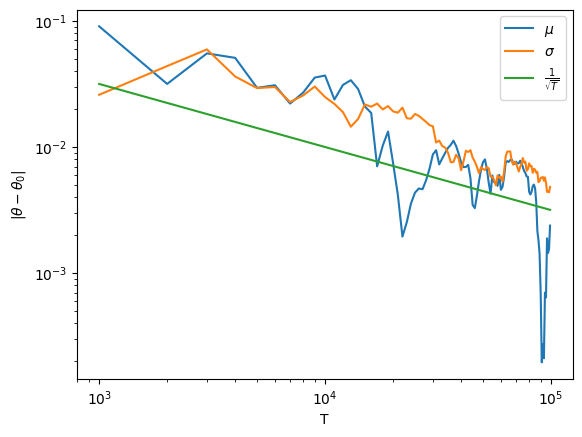

In [48]:
plt.loglog(n_values, np.abs(thetas[:, 0]-musubzero), label=r'$\mu$')
plt.loglog(n_values, np.abs(thetas[:, 1]-sigsubzero), label=r'$\sigma$')
plt.loglog(n_values, 1/np.sqrt(n_values), label=r'$\frac{1}{\sqrt{T}}$')

plt.xlabel('T')
plt.ylabel(r'$|\theta-\theta_0|$')
plt.legend()
plt.show()

## 2 Stage GMM (with optimal weighting matrix)

In [56]:
class GMMEstimator:
    def __init__(self, y, N, startvalues):
        self.y = y
        self.N = N
        self.startvalues = startvalues
        self.g = None  # Initialize g as None
        self.W = np.eye(2)  # Initial weighting matrix: identity

    def myfun(self, theta, W):
        # Compute the individual moment conditions for each observation
        self.g = np.column_stack([
            self.y - theta[0],
            self.y**2 - theta[0]**2 - theta[1]**2
        ])
        
        # Compute the sample moments (mean of g)
        G = np.mean(self.g, axis=0).reshape(-1, 1)

        # Compute the GMM objective function with the weighting matrix
        GMM = G.T @ W @ G
        return GMM.item()  # Return the scalar value

    def first_stage_estimation(self):
        # Perform the first-stage GMM estimation
        result_1 = minimize(
            fun=self.myfun,
            x0=self.startvalues,
            args=(self.W,),
            method='BFGS',
            options={'disp': True}
        )
        thetaHAT_1 = result_1.x
        GMMvalue_1 = result_1.fun

        print("\nFirst-stage estimates:")
        print("thetaHAT =", thetaHAT_1)
        print("GMMvalue =", GMMvalue_1)

        return thetaHAT_1

    def second_stage_estimation(self, thetaHAT_1):
        # Compute the optimal weighting matrix
        W_optimal = np.linalg.inv((self.g.T @ self.g) / self.N)

        # Perform the second-stage GMM estimation
        result_2 = minimize(
            fun=self.myfun,
            x0=self.startvalues,
            args=(W_optimal,),
            method='BFGS',
            options={'disp': True}
        )
        thetaHAT_2 = result_2.x
        GMMvalue_2 = result_2.fun

        print("\nSecond-stage estimates:")
        print("thetaHAT =", thetaHAT_2)
        print("GMMvalue =", GMMvalue_2)

        return thetaHAT_2


In [59]:
# Set random seed for reproducibility
np.random.seed(12)

N = 200  # Sample size

# Population parameters
musubzero = 5.0
sigsubzero = 2.0

# Generate simulated data
y = sigsubzero * np.random.randn(N) + musubzero

# Starting values for the parameters
startvalues = [0.0, 0.01]

# Create GMM estimator object
gmm_estimator = GMMEstimator(y, N, startvalues)

# First-stage estimation
thetaHAT_1 = gmm_estimator.first_stage_estimation()

# Second-stage estimation
thetaHAT_2 = gmm_estimator.second_stage_estimation(thetaHAT_1);

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 72
         Gradient evaluations: 24

First-stage estimates:
thetaHAT = [4.63944894 2.07368061]
GMMvalue = 2.2824147405684435e-13
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 17
         Function evaluations: 90
         Gradient evaluations: 30

Second-stage estimates:
thetaHAT = [4.63944635 2.073676  ]
GMMvalue = 1.0824782526055311e-11
